#Titanic: Predicting Survival

##Kaggle Competition: https://www.kaggle.com/c/titanic/data

In [92]:
import pandas as pd
import pylab as plt

In [46]:
titanic = pd.read_csv("train.csv")

In [89]:
%matplotlib inline

In [47]:
# Print the first 5 rows of the dataframe.
print(titanic.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [48]:
print(titanic.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


####Age Column
From the description we can see many ages are missing, so replace missing ages with median age

In [49]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

####Gender Column

Find all the unique genders in case missing values were replaced with different value.

In [50]:
# Find all the unique genders -- the column appears to contain only male and female.
print(titanic["Sex"].unique())

['male' 'female']


the column appears to contain only male and female.

The Sex column is non-numeric, but we want to keep it around -- it could be very informative. We can convert it to a numeric column by replacing each gender with a numeric code. A machine learning algorithm will then be able to use these categories to make predictions.

We will change Male to 0 and Female to 1

In [51]:
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0

titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

####Embarked Column
We now can convert the Embarked column to codes the same way we converted the Sex column. The unique values in Embarked are S, C, Q, and missing (nan). Each letter is an abbreviation of an embarkation port name.

In [52]:
print(titanic["Embarked"].unique())

['S' 'C' 'Q' nan]


In [53]:
# bool = titanic['Embarked'] == 'S'
# S_embarked = titanic['Embarked'][bool]
# len(S_embarked)

print('S Deparutures:', len(titanic['Embarked'][titanic['Embarked'] == 'S']))
print('C Deparutures:', len(titanic['Embarked'][titanic['Embarked'] == 'C']))
print('Q Deparutures:', len(titanic['Embarked'][titanic['Embarked'] == 'Q']))

S Deparutures: 644
C Deparutures: 168
Q Deparutures: 77


The first step is to replace the missing values in the column. The most common embarkation port is S, so let's assume everyone got on there. Replace all the missing values in the Embarked column with S.

In [54]:
titanic['Embarked'].fillna('S', inplace=True)
# titanic["Embarked"] = titanic["Embarked"].fillna("S")

In [62]:
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

##Linear Regression

We can now use linear regression to make predictions on our training set.

We want to train the algorithm on different data than we make predictions on. This is critical if we want to avoid overfitting. Overfitting is what happens when a model fits itself to "noise", not signal. Every dataset has its own quirks that don't exist in the full population. For example, if I asked you to predict the top speed of a car from its horsepower and other characteristics, and gave you a dataset that randomly had cars with very high top speeds, you would create a model that overstated speed. The way to figure out if your model is doing this is to evaluate its performance on data it hasn't been trained using.

Every machine learning algorithm can overfit, although some (like linear regression) are much less prone to it. If you evaluate your algorithm on the same dataset that you train it on, it's impossible to know if it's performing well because it overfit itself to the noise, or if it actually is a good algorithm.

Luckily, cross validation is a simple way to avoid overfitting. To cross validate, you split your data into some number of parts (or "folds"). Lets use 3 as an example. You then do this:

Combine the first two parts, train a model, make predictions on the third.

Combine the first and third parts, train a model, make predictions on the second.

Combine the second and third parts, train a model, make predictions on the first.

This way, we generate predictions for the whole dataset without ever evaluating accuracy on the same data we train our model using.

In [72]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

###Evaluating Error

Figure out what proportion of the values in predictions are the exact same as the values in titanic["Survived"]. This calculation should be left as a float (decimal) and assigned to the variable accuracy.

In [73]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)

/Users/molliepettit/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [74]:
accuracy

0.78338945005611671

##Logistic Regression

In [76]:
from sklearn. linear_model import LogisticRegression
from sklearn import cross_validation


# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


##Random Forest

In [81]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.800224466891


####Parameter tuning
The first, and easiest, thing we can do to improve the accuracy of the random forest is to increase the number of trees we're using. Training more trees will take more time, but because of the fact that we're averaging many predictions made on different subsets of the data, having more trees will increase accuracy greatly (up to a point).

We can also tweak the min_samples_split and min_samples_leaf variables to reduce overfitting. Because of how a decision tree works (as we explained in the video), having splits that go all the way down, or overly deep in the tree can result in fitting to quirks in the dataset, and not true signal. Thus, increasing min_samples_split and min_samples_leaf can reduce overfitting, which will actually improve our score, as we're making predictions on unseen data. A model that is less overfit, and that can generalize better, will actually perform better on unseen data, but worse on seen data.

In [82]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.819304152637


###Generating New Features

We can also generate new features. Here are some ideas:

The length of the name -- this could pertain to how rich the person was, and therefore their position in the Titanic.
The total number of people in a family (SibSp + Parch).

In [84]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

####Using Title
We can extract the title of the passenger from their name. The titles take the form of Master., Mr., Mrs.. There are a few very commonly used titles, and a "long tail" of one-off titles that only one or two passengers have.

We'll first extract the titles with a regular expression, and then map each unique title to an integer value.

We'll then have a numeric column that corresponds to the appropriate Title.

In [86]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Capt          1
Sir           1
Lady          1
Don           1
Countess      1
Ms            1
Mme           1
Jonkheer      1
dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
dtype: int64


####Family Groups

We can also generate a feature indicating which family people are in. Because survival was likely highly dependent on your family and the people around you, this has a good chance at being a good feature.

To get this, we'll concatenate someone's last name with FamilySize to get a unique family id. We'll then be able to assign a code to each person based on their family id.

In [88]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


####Finding the Best Features

Feature engineering is the most important part of any machine learning task, and there are lots more features we could calculate. But we also need a way to figure out which features are the best.

One way to do this is to use univariate feature selection. This essentially goes column by column, and figures out which columns correlate most closely with what we're trying to predict (Survived).

As usual, sklearn has a function that will help us with feature selection, SelectKBest. This selects the best features from the data, and allows us to specify how many it selects.

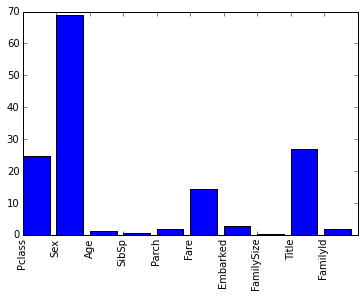

In [93]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

In [94]:
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.811447811448


##Processing Test Set

we need to take the exact same steps on the test data that we took on the training data. If we don't do the exact same operations, then we won't be able to make valid predictions on it. These operations are all the changes we made to the columns before.

In [99]:
titanic_test = pd.read_csv("test.csv")

titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

#we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
# print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
# print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

##Generating a Submission File

Now we have everything we need to generate a submission for the competition.

First, we have to train an algorithm on the training data. Then, we make predictions on the test set. Finally, we'll generate a csv file with the predictions and passenger ids.

Once all steps are finished, output to a csv by using submission.to_csv("kaggle.csv", index=False). 

In [101]:
from sklearn.ensemble import GradientBoostingClassifier
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

In [102]:
submission.to_csv("Titanic_kaggle.csv", index=False)

##Final Thoughts

Could still try creating more features...

    -Try using features related to the cabins.
    -See if any family size features might help -- do the number of women in a family make the whole family more likely to survive?
    -Does the national origin of the passenger's name have anything to do with survival?


There's also a lot more we can do on the algorithm side:

    -Try the random forest classifier in the ensemble.
    -A support vector machine might work well with this data.
    -We could try neural networks.
    -Boosting with a different base classifier might work better.
    -And with ensembling methods:

Could majority voting be a better ensembling method than averaging probabilities?
This dataset is very easy to overfit on because there isn't a lot of data, so you'll be grinding for small accuracy gains. Could also try a different Kaggle competition with more data and richer features to sink into.